# protostars
## 05- Solid angle ratio
### IV. Flux ratio is still wrong

Spot check

gully  
March 13, 2017

In [1]:
import pandas as pd

In [2]:
ws = np.load("../sf/exp2/output/veil1/run03/temp_emcee_chain.npy")

### Phoenix
see Husser et al. 2013

In [36]:
import Starfish
from Starfish.grid_tools import PHOENIXGridInterfaceNoAlpha as PHOENIX
mygrid = PHOENIX(norm=False, base='/Users/gully/GitHub/Starfish/libraries/raw/PHOENIX/', air=False,
                wl_range=[50, 100000.0])
#mygrid2 = PHOENIX(norm=True, base='/Users/gully/GitHub/Starfish/libraries/raw/PHOENIX/', air=False)

From the Husser et al. 2013 paper:  

>The files always contain one single primary extension, which holds the flux of the spectrum in units of *[erg/s/cm2/cm]* **on the stellar surface**.

**on the stellar surface** means they've integrated over a stellar disk filling half the sky, in other words, [they've integrated over solid angle](https://en.wikipedia.org/wiki/Black-body_radiation#Stefan.E2.80.93Boltzmann_law):

$\int d\Omega\, \cos\theta = \int_0^{2\pi}d\phi \int_0^{\pi/2}d\theta\, \sin\theta \cos\theta = \pi.$

Which yields a factor of $\pi$.  Makes sense!

In [4]:
T_eff = 2900

In [5]:
p_A = np.array([T_eff, 3.5, 0.0])
flux_A, hdr_A = mygrid.load_flux(p_A)
flux_B, hdr_B = mygrid2.load_flux(p_A)
flux_A_perAngs = flux_A*1.0E-8

### Black bodies from `astropy`

In [6]:
from astropy import units as u
from astropy.analytic_functions import blackbody_lambda, blackbody_nu

In [7]:
wavelengths = mygrid.wl * u.AA
bb_A_raw = blackbody_lambda(wavelengths, T_eff * u.K)

In [8]:
bb_A_raw.unit

Unit("erg / (Angstrom cm2 s sr)")

The desired flux units are: `erg/s/cm2/A`

In [9]:
bb_A = bb_A_raw.to(u.erg/(u.s*(u.cm**2)*u.Angstrom*u.sr))

In [10]:
bb_A_AtSurface = bb_A * np.pi*u.sr

In [11]:
bb_A_AtSurface.unit

Unit("erg / (Angstrom cm2 s)")

Which should be the same as `Phoenix` *when used in Starfish*!

(2000, 25000)

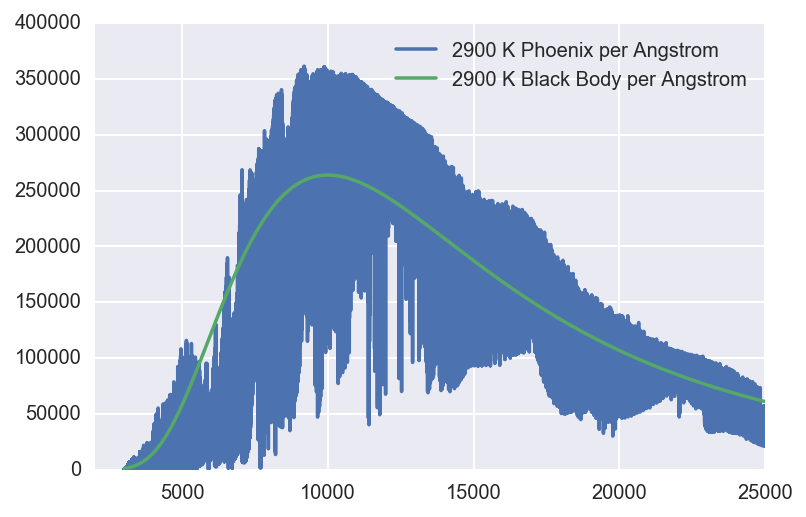

In [12]:
plt.plot(mygrid.wl, flux_A_perAngs, label='2900 K Phoenix per Angstrom')
plt.plot(wavelengths.value, bb_A_AtSurface.value, label='2900 K Black Body per Angstrom')

plt.legend(loc='best')
#plt.yscale('log')
plt.xlim(2000, 25000)

Looks good.

Now compare to the spectrum from the model:

In [13]:
draws = pd.read_csv('../sf/exp1/output/veil1/run01/models_ff-05_50_95.csv')

In [14]:
raw_mods = np.load('../sf/exp2/output/veil1/run03/temp_raw_models.npy')

In [15]:
star, disk, cheb, flux_mean, qq = (raw_mods[0,0,i] for i in range(5))

In [16]:
ws.shape

(40, 3, 14)

In [17]:
Omega1, Omega2 = 10**ws[0, 0, 5], 10**ws[0, 0, 7]
Omega1, Omega2

(0.49491401121537787, 0.031896667180973448)

Our model is:
$\mathsf{M}_{\mathrm{net}} = \mathsf{M}_1 + \mathsf{M}_2$

The flux-corrected model should be:

$\mathsf{M}_1 = \Omega_{1} \; f_{\lambda, 1} \; P$  
$\mathsf{M}_2 = \Omega_{2} \; f_{\lambda, 2} \; P \; q_{M_1}$ 

Where:  

- $\mathsf{M}_1$  is the post-processed forward stellar photosphere model  
- $\mathsf{M}_2$  is the post-processed forward disk model  
- $P $ is the Chebyshev polynomial vector
- $f_{\lambda, 1} $ is normalized flux from the stellar photosphere
- $f_{\lambda, 2} $ is relative flux from the disk
- $\Omega_{i}$ is the solid angle from component $i$
- $q_{M_1}$ is the flux ratio that was divided out in the normalization process

So let's plot the fluxes:

$f_{\lambda, 1} = \mathsf{M}_1 / [\Omega_{1} \; P]$  
$f_{\lambda, 2} = \mathsf{M}_2 / [\Omega_{2} \; P \; q_{M_1}]$ 

They *should* match up...

In [18]:
import Starfish.constants as C

In [19]:
C.F_sun

63155907420.64097

In [20]:
ws[0, 0, 0], ws[0, 0, 6]

(2894.4044611202335, 1100.4331642233526)

### Spot check the black body

The disk temp isn't exactly 1100

In [21]:
bb_disk_raw = blackbody_lambda(wavelengths, ws[0, 0, 6] * u.K)
bb_disk_perAngs = bb_disk_raw.to(u.erg/(u.s*(u.cm**2)*u.Angstrom*u.sr))* np.pi*u.sr

(20000, 25000)

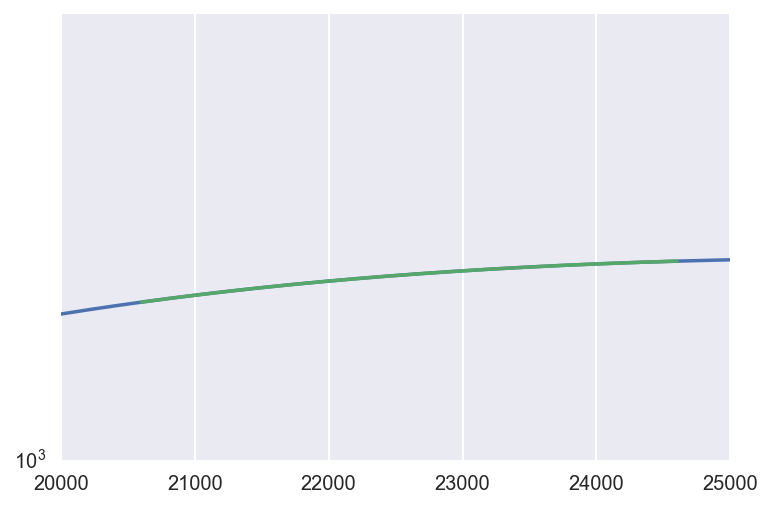

In [22]:
plt.plot(wavelengths.value, bb_disk_perAngs.value, label='Black Body')
plt.plot(draws.wl, disk/cheb/Omega2)

plt.yscale('log')
plt.ylim(1.0E3, 5.0E3)
plt.xlim(20000, 25000)

Dead on.

### Spot check the stellar photosphere

$f_{\lambda, 1} = \mathsf{M}_1 / [\Omega_{1} \; P ]$    

In [23]:
np.log10(qq)

1.2207084894460682

(20000, 25000)

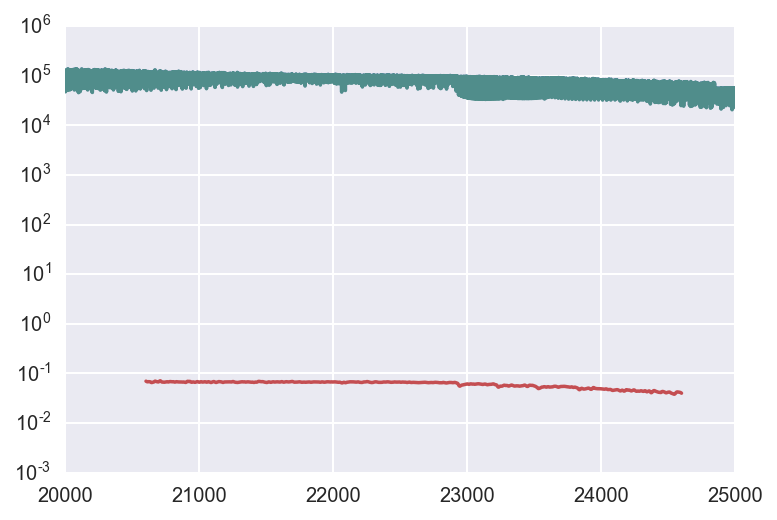

In [24]:
plt.plot(wavelengths.value, flux_A_perAngs, label='Phoenix grid A')
plt.plot(wavelengths.value, flux_B/qq, alpha=0.5,  label='Phoenix grid B')
plt.plot(draws.wl, star/cheb/Omega1)
plt.yscale('log')
plt.xlim(20000, 25000)

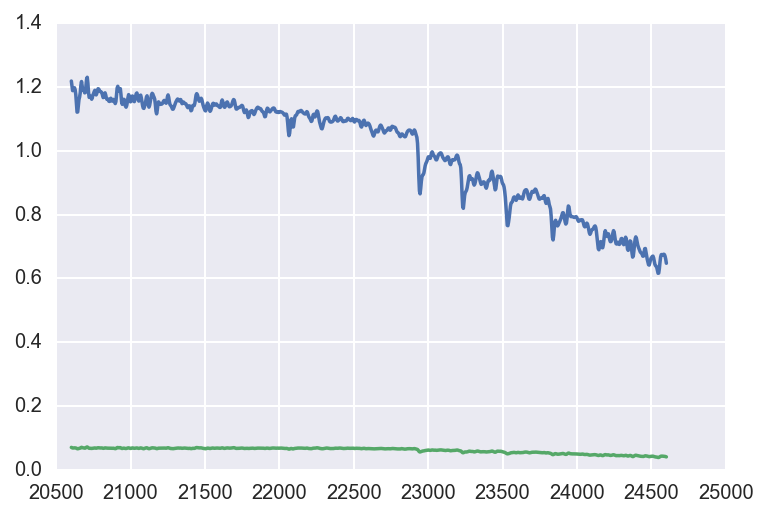

In [25]:
plt.plot(draws.wl, flux_mean)
plt.plot(draws.wl, star/cheb/Omega1)

In [26]:
np.mean(star/cheb/Omega1)

0.060291069430685421

Suspiciously close to 1... What's going on here?

In [27]:
mygrid.points

[array([ 2300,  2400,  2500,  2600,  2700,  2800,  2900,  3000,  3100,
         3200,  3300,  3400,  3500,  3600,  3700,  3800,  3900,  4000,
         4100,  4200,  4300,  4400,  4500,  4600,  4700,  4800,  4900,
         5000,  5100,  5200,  5300,  5400,  5500,  5600,  5700,  5800,
         5900,  6000,  6100,  6200,  6300,  6400,  6500,  6600,  6700,
         6800,  6900,  7000,  7200,  7400,  7600,  7800,  8000,  8200,
         8400,  8600,  8800,  9000,  9200,  9400,  9600,  9800, 10000,
        10200, 10400, 10600, 10800, 11000, 11200, 11400, 11600, 11800, 12000]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ]),
 array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ])]

In [28]:
from scipy.integrate import trapz

In [29]:
f, hdr = mygrid.load_flux([2300, 2.0, 0.0], norm=False)
f *= 1e-8/np.pi #convert from erg/cm^2/s/cm to erg/cm^2/s/A
F_bol = trapz(f, mygrid.wl)

In [30]:
F_bol # erg/cm^2/s

470780033.00899416

In [31]:
import astropy.constants as const

In [32]:
import astropy.units as u

In [33]:
f_bol_teff = const.sigma_sb * 2300.0**4.0 * u.K**4
f_bol_teff.to(u.erg/u.cm**2/u.s).value

1586802850.693

In [53]:
v1= []
for teff in mygrid.points[0]:
    f, hdr = mygrid.load_flux([teff, 4.0, 0.0])
    f *= 1e-8 #convert from erg/cm^2/s/cm to erg/cm^2/s/A
    F_bol = trapz(f, mygrid.wl)
    f_bol_teff = const.sigma_sb * teff**4.0 * u.K**4
    f_b_out = f_bol_teff.to(u.erg/u.cm**2/u.s).value
    v1.append([teff, F_bol, f_b_out])

In [54]:
arr1 = np.array(v1)

In [55]:
arr1.shape

(73, 3)

In [60]:
sns.set_context('talk')

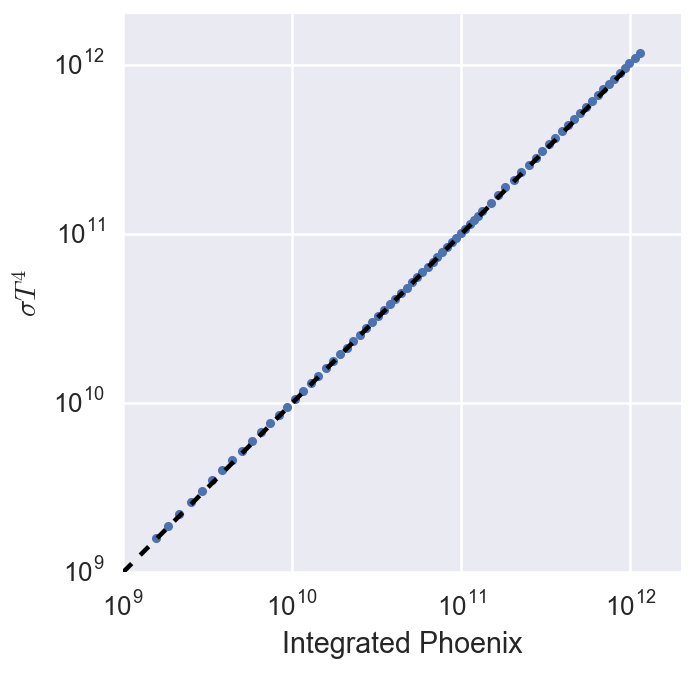

In [61]:
plt.figure(figsize=(5,5))
plt.plot(arr1[:, 1], arr1[:,2], '.')
plt.plot([1.0E9, 1.0e12], [1.0e9, 1e12], '--k')
plt.xlabel('Integrated Phoenix')
plt.ylabel('$\sigma T^4$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(0, 2e12)
plt.xlim(0, 2e12);